# Parametrized library functions: Lorenz with parameterized forcing

This notebook performs SR3 with parameter estimation on a Lorenz system with parameterized forcing. The optimization performs a joint inference of the terms in the dynamics (the sparse coefficients) and the parameters in the parameterized forcing.

In [1]:
import sys
import numpy as np
from scipy.integrate import odeint

import pysindy as ps
sys.path.insert(0, '..')
from utils import *
from sindy_forcing import SINDyForcing
from sr3_forcing import SR3Forcing

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Generate training data

In [2]:
np.random.seed(1)

# time grid set up
ts = 0.0
te = 10.0
dt = .005
t = np.arange(ts,te,dt)

# set up forcing
forcing_strength = 20.
param_alpha = np.array([.8,3.])
forcing = lambda t : forcing_strength*np.tanh(param_alpha[0]*t-param_alpha[1])

# ode set up
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]
lorenz_forced = lambda z,t : [10*(z[1] - z[0]) + forcing(t), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

# generate training data
n_trajectories = 1
x0 = [8,-7,27]
x = odeint(lorenz_forced, x0, t)
x_unforced = odeint(lorenz, x0, t)
x_noisy = add_noise(x, std=1e-3)

# true coefficient matrix
true_coefficients = np.zeros((10,3))
true_coefficients[1,0] = -10
true_coefficients[2,0] = 10
true_coefficients[1,1] = 28
true_coefficients[2,1] = -1
true_coefficients[6,1] = -1
true_coefficients[3,2] = -8/3
true_coefficients[5,2] = 1

(-0.4997500000000001,
 10.494750000000002,
 -21.89605830243818,
 21.993132729040422)

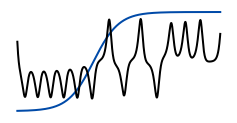

In [3]:
plt.figure(figsize=(4,2))
plt.plot(t, forcing(t), linewidth=2, color='#004AA8')
plt.plot(t, x_noisy[:,0], 'k', linewidth=2)
plt.axis('off')
# plt.savefig('lorenz_forced1.pdf', dpi=600)

## Fit SINDy model without the forcing function

In [4]:
threshold = 0.1
nu = 0.1
library = ps.PolynomialLibrary(degree=3)

In [5]:
sr3_optimizer = ps.SR3(threshold=threshold, nu=nu)
diff = ps.FiniteDifference(drop_endpoints=True)
model_noForcing = ps.SINDy(optimizer=sr3_optimizer, feature_library=library, feature_names=['x','y','z'],
                          differentiation_method=diff)
model_noForcing.fit(x_noisy, t=dt, unbias=False)
model_noForcing.print()

(x)' = 37.230 1 + 7.176 x + -1.464 y + -4.994 z + -1.467 x^2 + 1.636 x y + -0.596 x z + -0.400 y^2 + 0.586 y z + 0.222 z^2
(y)' = 28.039 x + -1.003 y + -1.003 x z
(z)' = -2.659 z + 1.005 x y


(-99.95, 2098.95, -19.107878208261003, 35.52821872424503)

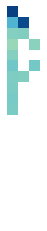

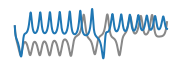

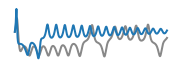

In [6]:
clims = [-30,30]
cmap = cm.GnBu

plt.figure()
plt.imshow(sigma_plot_sparsity(model_noForcing.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
# plt.savefig('forcing_coefficients_noAlpha.pdf', dpi=600)

# simulate training trajectory
x_simulate_noforcing = model_noForcing.simulate(x_noisy[0], t)
plt.figure(figsize=(3,1))
plt.plot(x_noisy[:,0], '#888888', linewidth=2)
plt.plot(x_simulate_noforcing[:,0], linewidth=2)
plt.axis('off')

# simulate test trajectory
x0_test = np.array([10,10,-10])
x_simulate_true = odeint(lorenz_forced, x0_test, t)
x_simulate_noforcing = model_noForcing.simulate(x0_test, t)

plt.figure(figsize=(3,1))
plt.plot(x_simulate_true[:,0], '#888888', linewidth=2)
plt.plot(x_simulate_noforcing[:,0], linewidth=2)
plt.axis('off')
# plt.savefig('forcing_sim_noAlpha.pdf', dpi=600)

## Fit SINDy model with parameterized forcing

In [7]:
forcing_functions = [lambda forcing_params,t : np.tanh(forcing_params[0]*t - forcing_params[1])]

model = SINDyForcing(2, forcing_functions, feature_library=library, feature_names=['x','y','z'],
                     differentiation_method=diff, threshold=threshold, nu=nu)
model.fit(x_noisy, t=dt, unbias=False, forcing_input=t[1:-1], initial_forcing_params=np.array([5,10]))

<ipython-input-7-810d1ef910ba>:1: RuntimeWarning: overflow encountered in tanh
  forcing_functions = [lambda forcing_params,t : np.tanh(forcing_params[0]*t - forcing_params[1])]
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SINDyForcing(differentiation_method=FiniteDifference(drop_endpoints=True),
             feature_library=PolynomialLibrary(degree=3),
             feature_names=['x', 'y', 'z'], forcing_functions=None,
             n_forcing_params=None)

(-99.95, 2098.95, -17.950264844492164, 25.602504693351467)

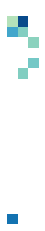

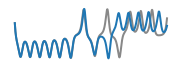

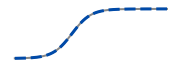

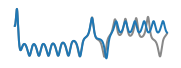

In [8]:
clims = [-30,30]
cmap = cm.GnBu

plt.figure()
plt.imshow(sigma_plot_sparsity(model.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
# plt.savefig('forcing_coefficients.pdf', dpi=600)

x_simulate = model.simulate(x0, t, t)
plt.figure(figsize=(3,1))
plt.plot(x_noisy[:,0], '#888888', linewidth=2)
plt.plot(x_simulate[:,0], linewidth=2)
plt.axis('off')

plt.figure(figsize=(3,1))
plt.plot(forcing(t)/forcing_strength, '#888888', linewidth=2)
plt.plot(forcing_functions[0](model.model.steps[1][1].forcing_params_,t), '--', linewidth=3, color='#004AA8')
plt.axis('off')
# plt.savefig('forcing_term.pdf', dpi=600)

x_simulate = model.simulate(x0_test, t, t)
plt.figure(figsize=(3,1))
plt.plot(x_simulate_true[:,0], '#888888', linewidth=2)
plt.plot(x_simulate[:,0], linewidth=2)
plt.axis('off')
# plt.savefig('forcing_sim.pdf', dpi=600)